In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.functional import F

import os

In [2]:
with open("input.txt", "r") as file:
    text_corpus =   file.read().lower()
    


In [3]:
print(text_corpus[:500])

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us kill him, and we'll have corn at our own price.
is't a verdict?

all:
no more talking on't; let it be done: away, away!

second citizen:
one word, good citizens.

first citizen:
we are accounted poor


In [4]:

unique_chars = sorted(set(text_corpus))


char_to_token = {unique_chars[i]:i for i in range(len(unique_chars))}

token_to_char =  {i:unique_chars[i] for i in range(len(unique_chars))}


In [5]:
char_to_token

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'k': 23,
 'l': 24,
 'm': 25,
 'n': 26,
 'o': 27,
 'p': 28,
 'q': 29,
 'r': 30,
 's': 31,
 't': 32,
 'u': 33,
 'v': 34,
 'w': 35,
 'x': 36,
 'y': 37,
 'z': 38}

### Tokenize text


In [6]:
tokenized_text_corpus = [char_to_token[c] for c in text_corpus]

In [143]:
len(tokenized_text_corpus)

1115394

In [11]:
BLOCK_SIZE=128 #Context len
BATCH_SIZE=16



In [12]:
def get_batch():
    starting_indeces = np.random.randint(0, len(tokenized_text_corpus) - BLOCK_SIZE - 1, BATCH_SIZE)

    X_batch = [torch.tensor(tokenized_text_corpus[i : i + BLOCK_SIZE], ) for i in starting_indeces]
    y_batch = [torch.tensor(tokenized_text_corpus[i + 1: i + BLOCK_SIZE + 1],) for i in starting_indeces]
    
    X_batch, y_batch = torch.stack(X_batch), torch.stack(y_batch)   
    return (X_batch, y_batch)

x, y = get_batch()


In [14]:
x.shape

torch.Size([16, 128])

### Self-Attention 

In [146]:
B, T, C = 4, 8, 6#Batch, Time, COntext

xbow = torch.randn((B, T, C))

average_context_mask = torch.tril(torch.ones((T, T))) 
average_context_mask = average_context_mask / torch.sum(average_context_mask, axis=1, keepdim=True)

In [147]:
##version2

average_context_mask

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [148]:
print(average_context_mask.shape,  " @ ", xbow.shape)

average_context_mask @ xbow # (T, T) @ (B, T, C) is casted as (B, T, T) @ (B, T, C) --> (B, T, C)


torch.Size([8, 8])  @  torch.Size([4, 8, 6])


tensor([[[ 1.0576,  1.1407, -0.4468, -0.8311, -0.8251,  1.4819],
         [ 0.4253,  0.9326, -0.2250, -0.2587, -0.4464,  0.7988],
         [ 0.7126,  0.5104, -0.3250, -0.6765, -0.4654, -0.0484],
         [ 0.5150,  0.1689, -0.2499, -0.2823, -0.3035,  0.2565],
         [ 0.5282,  0.4694, -0.2789, -0.3591, -0.0849,  0.1925],
         [ 0.5214,  0.2179, -0.2767, -0.1682, -0.1827,  0.6431],
         [ 0.3523,  0.5230, -0.3747,  0.0717, -0.0179,  0.5877],
         [ 0.6608,  0.4665, -0.2276,  0.2110, -0.0401,  0.7891]],

        [[-1.3847,  1.2253,  1.1085, -1.7889,  1.0886,  0.4635],
         [-0.5235,  0.5816,  0.5388, -1.0386,  0.2094,  0.5534],
         [-0.2588,  1.5450,  0.0241, -0.1274,  0.1546, -0.2446],
         [-0.0845,  1.2615,  0.3053,  0.0259, -0.0995, -0.2703],
         [ 0.0265,  0.8963,  0.0484,  0.1281, -0.0583, -0.5142],
         [ 0.0268,  0.7341,  0.0705,  0.2035,  0.0471, -0.2255],
         [-0.0369,  0.5839,  0.1176,  0.2581,  0.0080, -0.1748],
         [ 0.0558,  0.5

In [149]:
##version 3

average_context_mask = torch.zeros((T, T))
average_context_mask = average_context_mask.masked_fill(torch.tril(torch.ones(T, T)) == 0, float("-inf"))
average_context_mask = F.softmax(average_context_mask, dim=1)

### One head of Self-Attention

In [150]:
###KEY PART of self-attention

B, T, C = 4, 8, 32 #Batch, Time, Channels (size of Embedding vec)
x = torch.randn(B,T,C)

#SINGLE HEAD self-attention
HEAD_SIZE=16

key = nn.Linear(C, HEAD_SIZE, bias=False)
query = nn.Linear(C, HEAD_SIZE, bias=False)
value = nn.Linear(C, HEAD_SIZE, bias=False)

#way of thinking
#X - is private info about each token

# Key - I am token N and here's what I have 
# Query - I am token N and here's what I look for
# Value - I am token N and  here's what I will communicate to you if you find me interesting

k = key(x) # (B, T, H)
q = query(x)


#compute scores for each token wrt to other tokens
#by dot product of query with keys of other tokens
wei = q @ k.transpose(-2, -1) #(B, T, T)

#masking out future

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf")) #forbide to talk to future-tokens (DECODER)
wei = F.softmax(wei, dim=-1)


v = value(x)

out = wei @ v  #each token gathers appropriate values of other tokens 


## Now, previous tokens have different weights (attention)
print(out.shape) #(BATCH, TIME, Head-size)


torch.Size([4, 8, 16])


In [151]:
#weighted attention

torch.round(wei[0], decimals=2)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8700, 0.1300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2200, 0.7700, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7900, 0.0500, 0.0400, 0.1200, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0700, 0.4900, 0.0700, 0.0100, 0.3700, 0.0000, 0.0000, 0.0000],
        [0.0800, 0.5800, 0.0500, 0.0300, 0.1200, 0.1500, 0.0000, 0.0000],
        [0.0800, 0.3300, 0.0900, 0.1500, 0.2400, 0.0800, 0.0300, 0.0000],
        [0.0100, 0.6500, 0.0100, 0.0000, 0.2600, 0.0200, 0.0200, 0.0300]],
       grad_fn=<RoundBackward1>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

### MultiHead Attention

multihead attention is basically applying many self-attentions in parralles and concatenating results

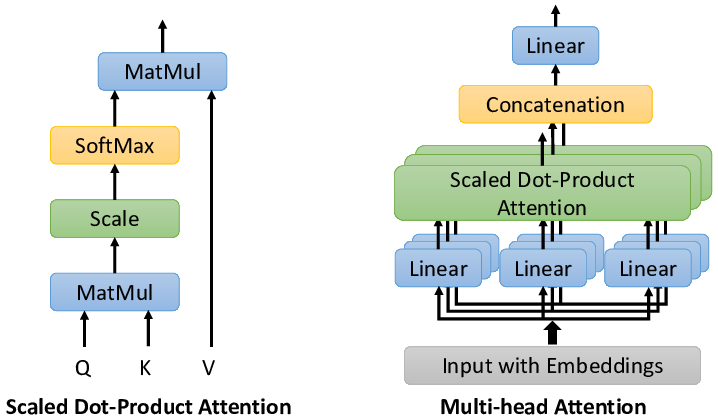

### TODO

1) We need to add simple feedforward NN on top of MultiHeadAttention Block
2) Add residual connections
3) Add Layer Norm

### Implementing MultiHead attention

In [50]:
#=========
#constants
N_EMBED=128
BATCH=16
N_HEADS=8
VOCAB_SIZE=len(unique_chars)
BLOCK_SIZE=32 #Context length
N_BLOCKS=8
MAX_TOKENS=100
LR=0.0005
EPOCHS=5000

#=======

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        
        self.head_size = head_size
        
        self.key_layer = nn.Linear(N_EMBED, head_size, bias=False)
        self.query_layer = nn.Linear(N_EMBED, head_size, bias=False)
        self.value_layer = nn.Linear(N_EMBED, head_size, bias=False)
        
    def forward(self, x):
        
        B, T, C = x.shape
        
        key = self.key_layer(x)
        query = self.query_layer(x)
        value = self.value_layer(x)
        
        #compute attention scores for each token wrt to other tokens
        attention_weights = (query @ key.transpose(-2, -1)) * C ** -0.5
        
        #mask out future
        tril = torch.tril(torch.ones(T, T))
        attention_weights = attention_weights.masked_fill(tril == 0, float("-inf"))
        #apply softmax to transform to prob distribution
        attention_weights = F.softmax(attention_weights, dim=-1)
        
        #gather values of interesting tokens and aggregate them for each token
        
        out = attention_weights @ value
        
        return out
        

In [51]:

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        self.projection = nn.Linear(N_EMBED, N_EMBED)
        
        
    def forward(self, x):
        
        head_outs = [head(x) for head in self.heads]
        
        #concatenate outputs of heads
        head_outs_concated = torch.cat(head_outs, dim=-1)
        
        out = self.projection(head_outs_concated)
        
        
        return out
    
    
class TransformerBlock(nn.Module): 
    def __init__(self, n_emb, n_heads):
        super().__init__()

        
        self.multihead_attention = MultiHeadAttention(n_heads, n_emb // n_heads)
        
        
        self.feedforward_nn = nn.Sequential(
            nn.Linear(n_emb, 4 * n_emb),
            nn.ReLU(),
            nn.Linear(4 * n_emb, n_emb),
        )
        
        self.layer_norm1  = nn.LayerNorm(n_emb)
        self.layer_norm2 = nn.LayerNorm(n_emb)
        
    def forward(self, x): #output shape is same as input
        
        x = self.multihead_attention(x) + x #add residual connections
        x = self.feedforward_nn(x) + x 
        
        return x
    

In [52]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(VOCAB_SIZE, N_EMBED)
        self.position_embedding_table = nn.Embedding(VOCAB_SIZE, N_EMBED)
        
        #init transformer blocks
        self.blocks = nn.Sequential(*[TransformerBlock(N_EMBED, N_HEADS) for _ in range(N_BLOCKS)])
        self.layer_norm = nn.LayerNorm(N_EMBED)
        
        self.final_linear = nn.Linear(N_EMBED, VOCAB_SIZE) #logits
        
        
    def forward(self, idx, targets=None):
        #idx - tensor of indices of tokens
        
        
        B, T = idx.shape
        
        tok_emb = self.token_embedding_table(idx) #(B, T, N_EMB)
        pos_emb = self.position_embedding_table(torch.arange(T)) #(T, N_EMB)
        
        #sum token and position embedding
        x = pos_emb + tok_emb
        
        x = self.blocks(x) #(B, T, N_EMB)
        x = self.layer_norm(x) #(B, T, N_EMB)
        logits = self.final_linear(x) #(B, T, VOCAB_SIZE) - produces logits
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            
            logits = logits.view(B*T, C)
            
            targets = targets.view(B*T,)
            
            loss = F.cross_entropy(logits, targets)
        
        
        
        return logits, loss
        

    def generate(self, idx, max_tokens=100):
        
        # idx is (B, T) array of indices in the current context
        
        for _ in range(max_tokens):
            
            #crop last context
            idx_cond = idx[:, -BLOCK_SIZE:]
            
            #get predicitons
            logits, loss = self(idx_cond)
            
            #focus only on last time-step
            logits = logits[:, -1, :] #(B, C)
            
            #apply softmax
            tok_probs = F.softmax(logits, dim=-1)
            
            #sample from dist
            idx_next = torch.multinomial(tok_probs, num_samples=1)
            
            #append new token
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx
        

In [53]:
model = BigramLanguageModel()


print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
    x_batch, y_batch = get_batch()
    
    logits, loss = model.forward(x_batch, y_batch)
    
    if ((epoch + 1) % 100 == 0 or epoch == 0):
        print("EPOCH# ", epoch + 1 ," LOSS = ", loss)
    
    # evaluate the loss
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

1.598375 M parameters
EPOCH#  1  LOSS =  tensor(3.8830, grad_fn=<NllLossBackward0>)
EPOCH#  100  LOSS =  tensor(2.5995, grad_fn=<NllLossBackward0>)
EPOCH#  200  LOSS =  tensor(2.2862, grad_fn=<NllLossBackward0>)
EPOCH#  300  LOSS =  tensor(2.3033, grad_fn=<NllLossBackward0>)
EPOCH#  400  LOSS =  tensor(2.1631, grad_fn=<NllLossBackward0>)
EPOCH#  500  LOSS =  tensor(2.1651, grad_fn=<NllLossBackward0>)
EPOCH#  600  LOSS =  tensor(1.9977, grad_fn=<NllLossBackward0>)
EPOCH#  700  LOSS =  tensor(2.1604, grad_fn=<NllLossBackward0>)
EPOCH#  800  LOSS =  tensor(1.9605, grad_fn=<NllLossBackward0>)
EPOCH#  900  LOSS =  tensor(2.0599, grad_fn=<NllLossBackward0>)
EPOCH#  1000  LOSS =  tensor(1.9561, grad_fn=<NllLossBackward0>)
EPOCH#  1100  LOSS =  tensor(1.8959, grad_fn=<NllLossBackward0>)
EPOCH#  1200  LOSS =  tensor(1.9002, grad_fn=<NllLossBackward0>)
EPOCH#  1300  LOSS =  tensor(1.7810, grad_fn=<NllLossBackward0>)
EPOCH#  1400  LOSS =  tensor(1.9219, grad_fn=<NllLossBackward0>)
EPOCH#  1500  L

In [56]:
context = torch.zeros((1, 1), dtype=torch.long)

generated_text = [token_to_char[int(t)] for t in model.generate(context, max_tokens=2000)[0]]

In [57]:
print("".join(generated_text[1:]))

a wouldsuous dreadful in the instend
yond the tagets, and noim for turn me;
the'er veroffol! i not?
heaven stay, let leak's tween qued.
ere to news, i here the!

king evering therefore; quarrish
in soul rock thee-puning take upon ane to forso this befow
as you to the good but three, 'greet in an so,
i'll be think, to a vice on answing,
thou mark that she heavind, silquame dosure?
you hoursel from you thee.

paring entent.

penderon:
sisfee room our prince: thou wrel to a brother; vere yours?
nay then life: meane yorks home at mark under'd,
and eaceiver to whilse.

lucio:
ougo look, have done thou towe ie truthoms
do so offord?

hension to be not i world you be.

peter:
goods tuom of my fight-b mine more king,
and i
am never neess; thoughs know i have honour plant,
my brother is news with his sweaness,
i'll nome in a chast sons we of almine.

provost:
i pear be opend it!
please, from the
bill.

we gonzalance:
and peace these none she son of me troubs and forth: kindwar!

let must provin